In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


In [3]:
users = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_users.csv')   # профили
purchases = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_orders.csv') # покупки

In [4]:
# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])


In [5]:
observation_date = users['dt'].max()  # момент анализа

analysis_horizon = 7  # горизонт анализа

In [6]:
# получите сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(users, purchases, observation_date, analysis_horizon, dimensions=['channel'])

plt.figure(figsize=(20, 5)) # размер сетки для графиков


<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

Text(0.5, 1.0, 'Конверсия первых семи дней с разбивкой по каналам привлечения')

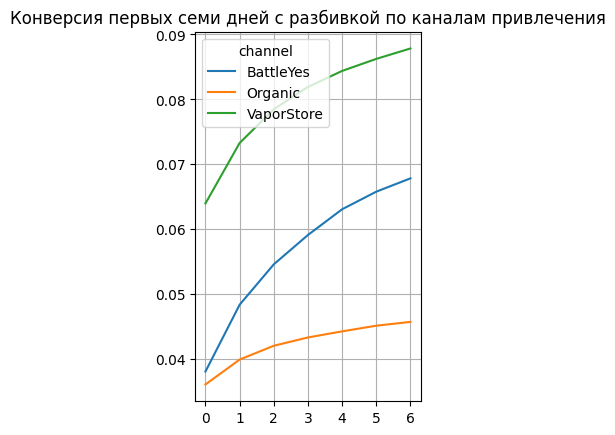

In [7]:
# в одной ячейке — кривые конверсии
report = conversion.drop(columns=['cohort_size'])
report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1)
)
plt.title('Конверсия первых семи дней с разбивкой по каналам привлечения')


Text(0.5, 1.0, 'Динамика конверсии 7-го дня с разбивкой по каналам привлечения')

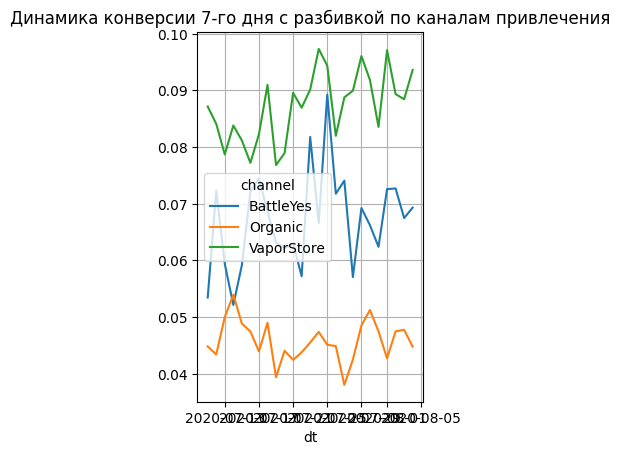

In [8]:
# во второй ячейке построим график истории изменений
# выберем нужный день «жизни» и построим сводную таблицу
# построим график и зададим его параметры
report = (
    conversion_history[6]
    .reset_index()
    .pivot_table(index='dt', columns='channel', values=6, aggfunc='mean')
    .fillna(0)  # заполняем пропуски на случай, если они возникнут
)
report.plot(
    # во второй ячейке строим график истории изменений
    grid=True, ax=plt.subplot(1, 2, 2)
)
plt.title('Динамика конверсии 7-го дня с разбивкой по каналам привлечения')
